In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
from adabmDCA.fasta import get_tokens
from annadca import annaRBMcat
from annadca.dataset import annaDataset
from annadca.utils import get_eigenvalues_history
from annadca.plot import plot_PCA

### Plot chains and data on the PCA

In [2]:
fname_data = "../example/data/PF00072_example.csv"
fname_weights = "../example/model/rbm-label_true-t10.7_weights.dat"
fname_chains = "../example/model/rbm-label_true-t10.7_chains.fasta"
fname_model = "../example/model/rbm-label_true-t10.7_params.h5"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [4]:
# Import dataset
tokens = get_tokens("protein")
dataset = annaDataset(
    path_data=fname_data,
    column_names="header",
    column_sequences="sequence_align",
    column_labels="label",
    alphabet="protein",
    path_weights=fname_weights,
    device=device,
    dtype=dtype,
)

data = dataset.data_one_hot
weights = dataset.weights.view(-1)
labels_data = dataset.to_label(dataset.labels_one_hot)

# Resample the sequences according to the weights
idxs = torch.multinomial(weights, len(dataset.data), replacement=True).cpu()
data = data[idxs]
labels_data = labels_data[idxs]

# Load the chains
rbm = annaRBMcat()
chains = rbm.load_chains(filename=fname_chains, alphabet=tokens, device=device, dtype=dtype)
labels_chains = dataset.to_label(chains["label"])

In [5]:
# Project data and chains on the same PCA space
pca = PCA(n_components=2)
data_flat = data.view(len(data), -1)
data_proj = pca.fit_transform(data_flat.cpu().numpy())
chains_proj = pca.transform(chains["visible"].view(len(chains["visible"]), -1).cpu().numpy())

In [6]:
# Define the colors
unique_labels = np.unique(labels_data)
cmap = plt.get_cmap("tab10", len(unique_labels))
label_to_color = {label.item(): cmap(i) for i, label in enumerate(unique_labels)}

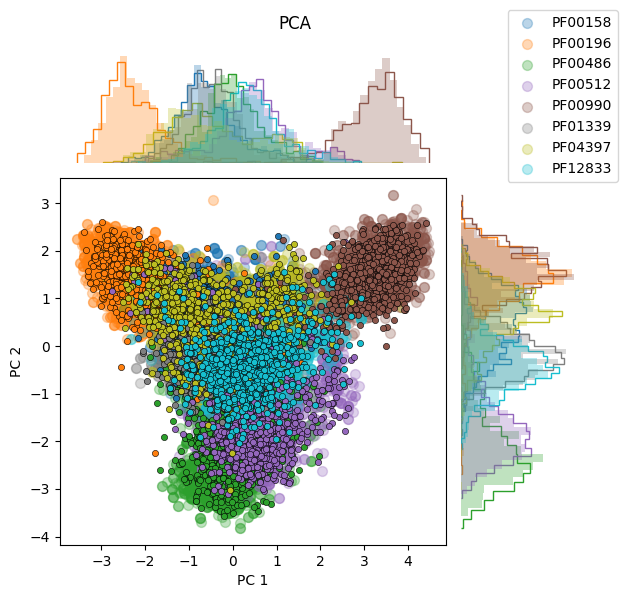

In [7]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=chains_proj,
    labels2=labels_chains,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="PCA",
    split_labels=True,
)
fig.legend(bbox_to_anchor=(1.05, 1.0))
fig.tight_layout()

### Sample unconditioned

In [9]:
# load model
rbm.load(fname_model, device=device, dtype=dtype)
#chains_init = rbm.init_chains(num_samples=10000)
samples = rbm.sample(gibbs_steps=1000, num_samples=10000)
samples_proj = pca.transform(samples["visible"].view(len(samples["visible"]), -1).cpu().numpy())
samples_labels = dataset.to_label(samples["label"])

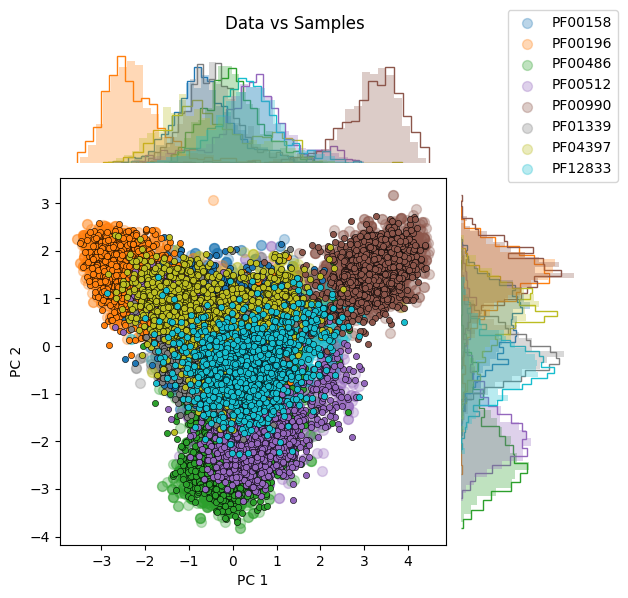

In [10]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=samples_proj,
    labels2=samples_labels,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="Data vs Samples",
    split_labels=True,
)
fig.legend(bbox_to_anchor=(1.05, 1.0))
fig.tight_layout()

In [11]:
# predict the labels and check the magnetization profile
samples_labels_pred = rbm.predict_labels(visibles=samples["visible"])

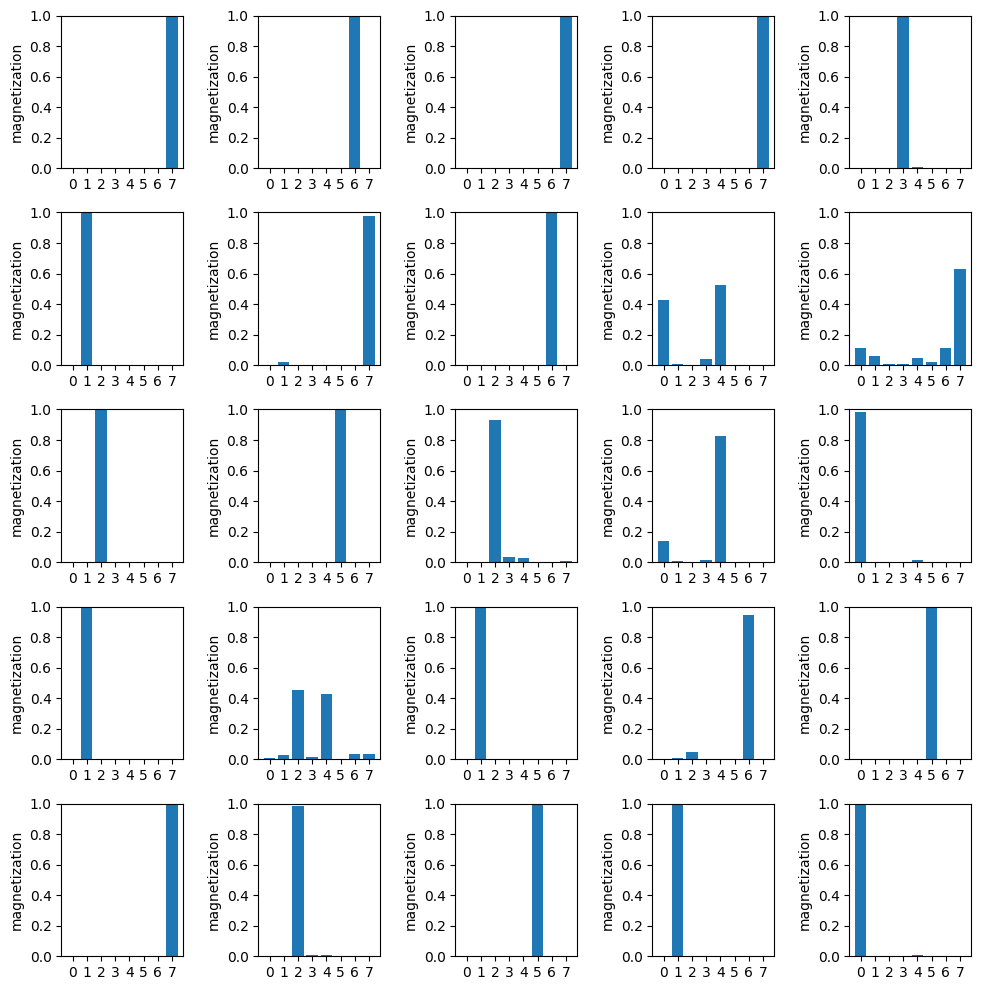

In [12]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.bar(np.arange(samples["label"].shape[1]), samples_labels_pred[i].cpu().numpy())
    ax.set_xticks(np.arange(samples["label"].shape[1]))
    ax.set_ylabel(f"magnetization")
    ax.set_ylim(0, 1)
fig.tight_layout()

In [13]:
updates, eigenvalues = get_eigenvalues_history(fname_model, target_matrix="weight_matrix", device=device, dtype=dtype)
updates, eigenvalues_labels = get_eigenvalues_history(fname_model, target_matrix="label_matrix", device=device, dtype=dtype)

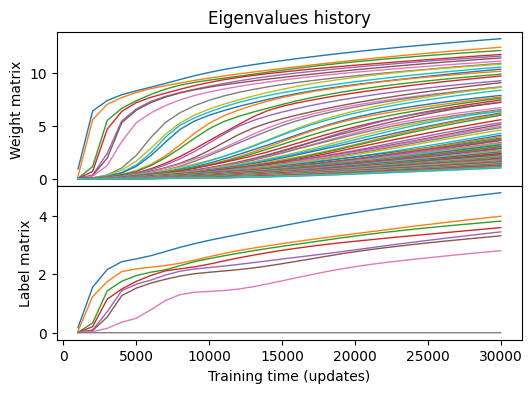

In [14]:
# Plot the eigenvalues history. first row is the weight matrix, second row is the label matrix.
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'hspace': 0})
ax[0].plot(updates, eigenvalues, lw=1)
ax[1].plot(updates, eigenvalues_labels, lw=1)
ax[1].set_xlabel("Training time (updates)")
ax[0].set_ylabel("Weight matrix")
ax[1].set_ylabel("Label matrix")
ax[0].set_title("Eigenvalues history");

### Conditioned sampling

In [15]:
rbm.load(fname_model, device=device, dtype=dtype)
cond_chains = rbm.sample_conditioned(
    gibbs_steps=1000,
    targets=dataset.labels_one_hot[idxs],
)

In [17]:
cond_chains_proj = pca.transform(cond_chains["visible"].view(len(cond_chains["visible"]), -1).cpu().numpy())
cond_chains_labels = labels_data

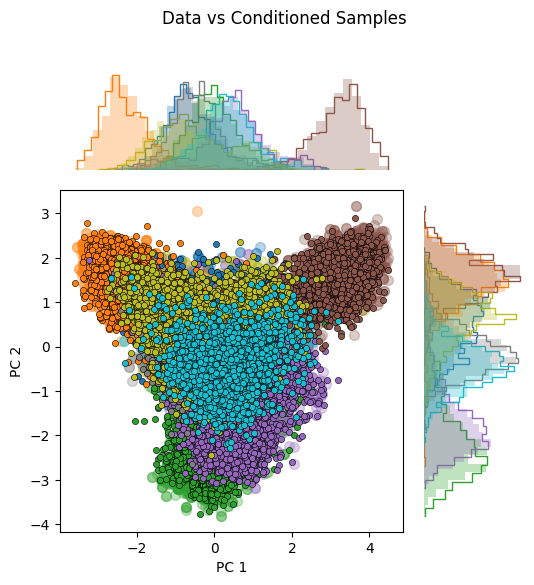

In [18]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=cond_chains_proj,
    labels2=cond_chains_labels,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="Data vs Conditioned Samples",
    split_labels=True,
)

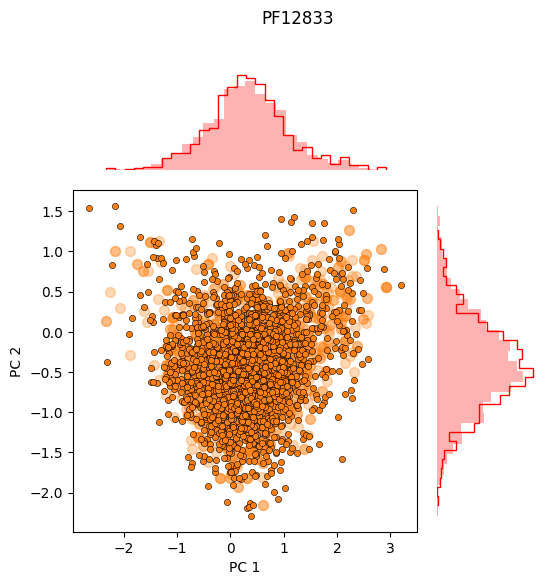

In [19]:
# Plot pca of conditioned chains and data but only one label
label_idx = 1
label = dataset.idx_to_label[label_idx]
mask_data = labels_data == label
mask_gen = cond_chains_labels == label
data_proj_label = data_proj[mask_data]
chains_proj_label = cond_chains_proj[mask_gen]

fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj_label,
    labels1=labels_data[mask_data],
    data2=chains_proj_label,
    labels2=cond_chains_labels[mask_gen],
    label_to_color={label: cmap(label_idx)},
    dim1=0,
    dim2=1,
    title=label,
    split_labels=False,
)

### Predict labels of the data

In [20]:
predictions = rbm.predict_labels(visibles=dataset.data_one_hot)

In [21]:
accuracy = (predictions.argmax(-1) == dataset.labels_one_hot.argmax(-1)).float().mean().item()
print(f"Train accuracy: {accuracy}")

Train accuracy: 0.9174361824989319
